# BLOCK 5: Clustering & Pattern Discovery (25 minutes)

## Clustering Fundamentals and Applications (5 minutes)

### What is Clustering?

**Clustering** is an unsupervised machine learning technique that groups similar data points together without prior knowledge of group labels. It discovers hidden patterns and structures in data by identifying natural groupings.

### Key Clustering Concepts:

1. **Similarity/Distance**: How we measure closeness between data points
2. **Centroids**: Representative points of clusters
3. **Intracluster Similarity**: Points within clusters are similar
4. **Intercluster Dissimilarity**: Points between clusters are different
5. **Cluster Validation**: Measuring clustering quality

### Clustering Applications in Oil Well Monitoring:

- **Operational States**: Identify distinct operational patterns
- **Sensor Grouping**: Find sensors that behave similarly
- **Fault Pattern Discovery**: Discover unknown fault signatures
- **Predictive Maintenance**: Group similar degradation patterns
- **Process Optimization**: Identify optimal operating conditions

### Our Clustering Analysis Approach:

**Data Strategy**: Using **raw 3W dataset** with 500-point time series
- **Raw Data Source**: Direct from 3W dataset folders (not windowed)
- **Fixed Length**: Resize each time series to exactly 500 points
- **Class Focus**: **Analyzing available fault classes** for focused comparison
- **Feature Matrix**: Each row = one 500-point time series per sensor

### Clustering Methods We'll Explore:

1. **K-means**: Centroid-based partitioning with elbow method & silhouette analysis
2. **Mean Shift**: Density-based clustering finding modes
3. **DBSCAN**: Density-based clustering with noise detection
4. **Evaluation**: Cluster quality metrics and interpretability

### Why Clustering Matters for 3W Dataset:
- **Pattern Discovery**: Find unknown operational patterns among selected fault types
- **Data Understanding**: Reveal natural groupings in sensor data
- **Dimensionality Analysis**: Understand sensor relationships
- **Fault Discrimination**: Distinguish between different fault types in the dataset
- **Process Knowledge**: Gain understanding of specific oil well failure modes

In [1]:
# ============================================================
# IMPORT LIBRARIES AND SETUP
# ============================================================

print("Setting up Clustering Analysis Environment")
print("=" * 45)

# Import required libraries
import sys
import os
import time
import numpy as np

# Add src to path
sys.path.append("src")

print("Importing clustering utilities...", end=" ")
from src.clustering_utils import ClusteringDataLoader
from src.data_persistence import DataPersistence
from src import config
print("OK")

# Configuration
TARGET_LENGTH = 500  # Fixed length for all time series
MAX_FILES_PER_CLASS = 50  # Limit files per class for manageable analysis
ENABLE_SAMPLING = True  # Enable sampling for faster processing
TARGET_CLASSES = [3, 4, 8]  # Preferred classes to analyze (will adapt if not available)

print(f"\nClustering Configuration:")
print(f"   • Target time series length: {TARGET_LENGTH} points")
print(f"   • Max files per class: {MAX_FILES_PER_CLASS}")
print(f"   • Sampling enabled: {ENABLE_SAMPLING}")
print(f"   • Preferred classes for analysis: {TARGET_CLASSES}")

# Initialize data loader
data_loader = ClusteringDataLoader(
    target_length=TARGET_LENGTH,
    max_files_per_class=MAX_FILES_PER_CLASS,
    enable_sampling=ENABLE_SAMPLING
)

print("\nSetup complete! Ready to load data.")

Setting up Clustering Analysis Environment
Importing clustering utilities... OK

Clustering Configuration:
   • Target time series length: 500 points
   • Max files per class: 50
   • Sampling enabled: True
   • Preferred classes for analysis: [3, 4, 8]

Setup complete! Ready to load data.
OK

Clustering Configuration:
   • Target time series length: 500 points
   • Max files per class: 50
   • Sampling enabled: True
   • Preferred classes for analysis: [3, 4, 8]

Setup complete! Ready to load data.


In [2]:
# ============================================================
# LOAD RAW 3W DATASET
# ============================================================

print("Loading Raw 3W Dataset for Clustering Analysis")
print("=" * 55)

try:
    # Initialize data persistence and load raw data
    persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
    raw_data_dir = os.path.join(persistence.cv_splits_dir, "raw")
    
    if not os.path.exists(raw_data_dir):
        raise FileNotFoundError(f"Raw data directory not found: {raw_data_dir}")
    
    # Load and process data using utility class
    start_time = time.time()
    raw_data_result = data_loader.load_raw_data(persistence, raw_data_dir)
    load_time = time.time() - start_time
    
    # Extract and filter data for target classes
    X_original = raw_data_result['X_original']
    y_labels = raw_data_result['y_labels']
    file_info = raw_data_result['file_info']
    fold_used = raw_data_result['fold_used']
    
    # Determine available classes and filter for analysis
    available_classes = sorted(np.unique(y_labels))
    target_classes = [3, 4, 8] if isinstance(available_classes[0], (int, np.integer)) else ['3', '4', '8']
    existing_classes = [cls for cls in target_classes if cls in available_classes]
    
    # Use first 3 available classes if target classes don't exist
    if not existing_classes:
        existing_classes = available_classes[:3] if len(available_classes) >= 3 else available_classes
        print(f"⚠️ Target classes not found, using: {existing_classes}")
    
    # Filter data to selected classes
    class_mask = np.isin(y_labels, existing_classes)
    X_original = X_original[class_mask]
    y_labels = y_labels[class_mask]
    file_info = [file_info[i] for i, mask in enumerate(class_mask) if mask]
    
    # Display summary
    unique_classes, counts = np.unique(y_labels, return_counts=True)
    print(f"\n✅ Data Loading Complete!")
    print(f"   • Total samples: {len(X_original)} | Features: {X_original.shape[1]} | Classes: {len(unique_classes)}")
    print(f"   • Load time: {load_time:.2f}s | Source: {fold_used}")
    print(f"   • Class distribution: {dict(zip(unique_classes, counts))}")
    
    # Store for subsequent cells
    clustering_data = {
        'X_original': X_original,
        'y_labels': y_labels,
        'file_info': file_info,
        'config': {
            'target_length': TARGET_LENGTH,
            'max_files_per_class': MAX_FILES_PER_CLASS,
            'sampling_enabled': ENABLE_SAMPLING,
            'fold_used': fold_used
        }
    }

except Exception as e:
    print(f"❌ Error loading data: {str(e)}")
    print("💡 Check if 3W dataset is properly extracted and accessible")
    clustering_data = None

Loading Raw 3W Dataset for Clustering Analysis
Loading Raw 3W Dataset for Clustering Analysis
Using fold_1 for clustering analysis

Loading train_data...

Loading test_data...

Loading test_data...

✅ Data Loading Complete!
   • Total samples: 197 | Features: 1500 | Classes: 3
   • Load time: 1.05s | Source: fold_1
   • Class distribution: {np.str_('3'): np.int64(49), np.str_('4'): np.int64(122), np.str_('8'): np.int64(26)}

✅ Data Loading Complete!
   • Total samples: 197 | Features: 1500 | Classes: 3
   • Load time: 1.05s | Source: fold_1
   • Class distribution: {np.str_('3'): np.int64(49), np.str_('4'): np.int64(122), np.str_('8'): np.int64(26)}


## 📊 Raw Data Loading Strategy

### Why Use Raw 3W Data for Clustering?

**Different from Previous Notebooks**: Here we use **raw time series** directly from the 3W dataset, not windowed data.

**Key Differences**:
- **Fixed Length**: Resize all time series to exactly 500 points
- **Direct Analysis**: Each complete sensor reading sequence becomes one data point
- **Class Focus**: Analyze specific fault classes (3, 4, 8) for comparison

**Clustering Context**: 
- Each row = one complete oil well operation sequence
- Goal: Discover natural groupings in operational patterns
- Unsupervised: We ignore class labels during clustering

In [3]:
# ============================================================
# DATA PREPROCESSING SETUP
# ============================================================

print("Data Preparation for Clustering Analysis")
print("=" * 45)

# Check if we have loaded data from previous cell
if "clustering_data" in locals() and clustering_data is not None:
    
    # Import preprocessing utilities
    from src.clustering_utils import ClusteringPreprocessor
    import warnings
    warnings.filterwarnings("ignore")

    # Extract raw data
    X_original = clustering_data["X_original"]
    y_labels = clustering_data["y_labels"]
    file_info = clustering_data["file_info"]

    print(f"Raw Data Overview:")
    print(f"   • Data shape: {X_original.shape}")
    print(f"   • Classes: {sorted(np.unique(y_labels))}")
    print(f"   • Total samples: {len(X_original)}")

    # Initialize preprocessor
    preprocessor = ClusteringPreprocessor()
    
    print("\nPreprocessor initialized. Ready for data preparation.")

else:
    print("No data available for preprocessing")
    print("   Please run the previous cells first to load raw 3W data")
    clustering_data = None

Data Preparation for Clustering Analysis
Raw Data Overview:
   • Data shape: (197, 1500)
   • Classes: [np.str_('3'), np.str_('4'), np.str_('8')]
   • Total samples: 197

Preprocessor initialized. Ready for data preparation.


## ⚙️ Data Preprocessing for Clustering

### Why Preprocessing Matters for Clustering

**Scaling Issues**: Different sensors have different ranges (pressure vs temperature)
- Without scaling: High-range sensors dominate distance calculations
- Solution: StandardScaler and MinMaxScaler

**Dimensionality Challenge**: 500-point time series = very high dimensions
- Problem: "Curse of dimensionality" affects clustering quality
- Solution: PCA to reduce dimensions while preserving variance

**Multiple Representations**: We prepare several data versions for comparison
- Scaled, normalized, and PCA-reduced variants
- Best clustering method may prefer different preprocessing

In [4]:
# ============================================================
# APPLY DATA PREPROCESSING
# ============================================================

if "preprocessor" in locals() and preprocessor is not None:
    
    print("Applying data preprocessing transformations...")
    
    # Prepare data with scaling and dimensionality reduction
    processed_data = preprocessor.prepare_data(X_original)
    
    # Extract processed datasets
    X_scaled = processed_data['X_scaled']
    X_normalized = processed_data['X_normalized']
    X_pca_50 = processed_data['X_pca_50']
    X_pca_95 = processed_data['X_pca_95']
    X_pca_2d = processed_data['X_pca_2d']
    pca_model = processed_data['pca_model']
    variance_info = processed_data['variance_info']
    
    print(f"\nPreprocessed Data Summary:")
    print(f"   • Original: {X_original.shape}")
    print(f"   • StandardScaled: {X_scaled.shape}")
    print(f"   • MinMax Normalized: {X_normalized.shape}")
    print(f"   • PCA (50 components): {X_pca_50.shape}")
    print(f"   • PCA (95% variance): {X_pca_95.shape}")
    print(f"   • PCA (2D visualization): {X_pca_2d.shape}")
    
    print(f"\nPCA Variance Analysis:")
    print(f"   • Components for 90% variance: {variance_info['n_components_90']}")
    print(f"   • Components for 95% variance: {variance_info['n_components_95']}")
    print(f"   • First 3 components variance: {variance_info['cumulative_variance'][2]:.1%}")

    # Update clustering_data with processed datasets
    clustering_data.update(processed_data)
    clustering_data['y_labels'] = y_labels
    clustering_data['file_info'] = file_info
    
    print("\nData preprocessing complete!")
    
else:
    print("Preprocessor not available. Please run the previous cell first.")
    clustering_data = None

Applying data preprocessing transformations...
Data Preparation for Clustering Analysis

Preprocessed Data Summary:
   • Original: (197, 1500)
   • StandardScaled: (197, 1500)
   • MinMax Normalized: (197, 1500)
   • PCA (50 components): (197, 50)
   • PCA (95% variance): (197, 51)
   • PCA (2D visualization): (197, 2)

PCA Variance Analysis:
   • Components for 90% variance: 33
   • Components for 95% variance: 51
   • First 3 components variance: 52.6%

Data preprocessing complete!


Creating Data Overview Visualizations...


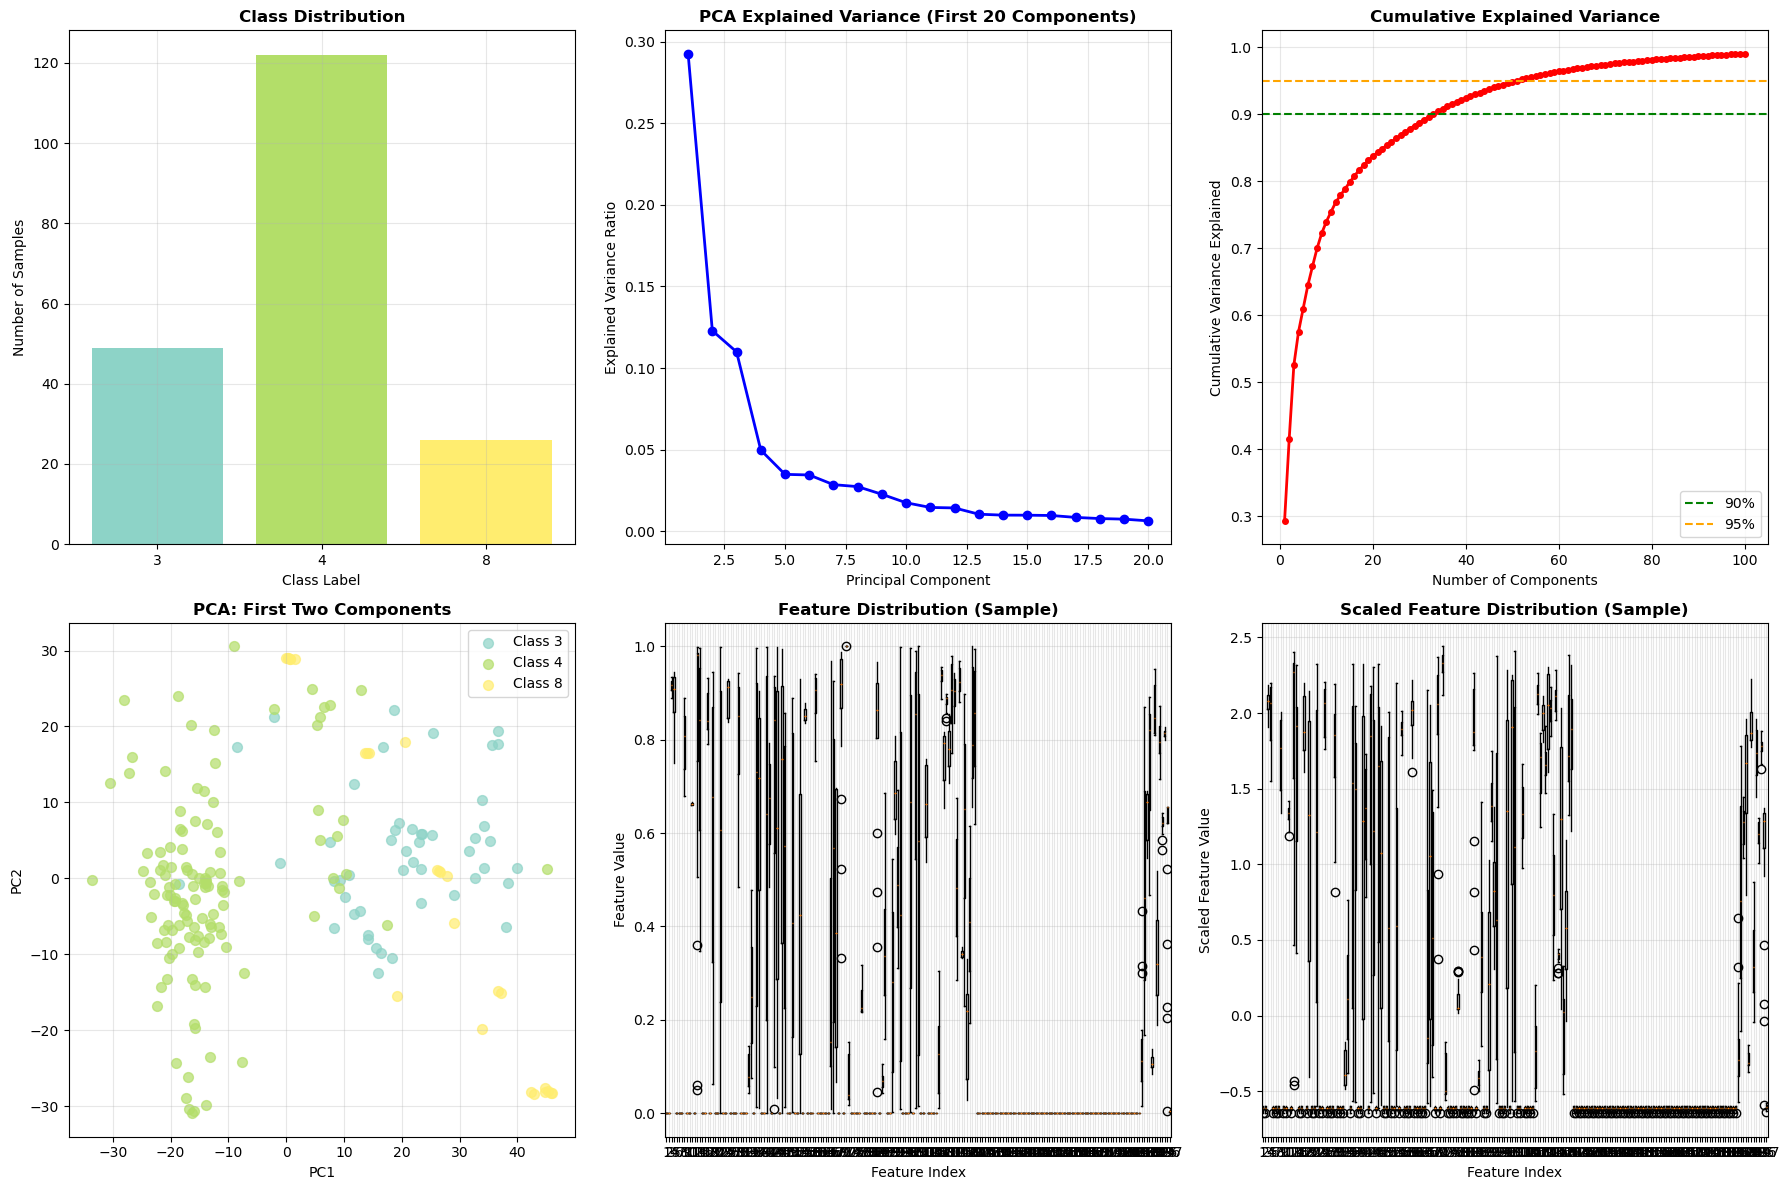

Data overview visualization complete!


In [5]:
# ============================================================
# DATA OVERVIEW VISUALIZATION
# ============================================================

if clustering_data is not None:
    
    print("Creating Data Overview Visualizations...")
    
    # Import visualization utilities
    from src.clustering_visualization import ClusteringVisualizer
    import matplotlib.pyplot as plt
    
    # Create visualizer
    visualizer = ClusteringVisualizer()
    
    # Create data overview plots
    visualizer.plot_data_overview(
        X_original=clustering_data['X_original'],
        X_scaled=clustering_data['X_scaled'],
        y_labels=clustering_data['y_labels'],
        pca_model=clustering_data['pca_model'],
        X_pca_2d=clustering_data['X_pca_2d']
    )
    
    print("Data overview visualization complete!")
    
else:
    print("No clustering data available for visualization")
    print("   Please run the previous cells first")

## 📈 Data Overview and PCA Analysis

### Understanding Your Data Before Clustering

**PCA Visualization**: Shows how much information is captured in lower dimensions
- First few components capture most variance
- Helps decide optimal dimensionality for clustering

**Class Distribution**: See how known fault types are distributed
- Remember: clustering ignores these labels
- We'll compare clustering results against known classes later

**Dimensionality Trade-off**: 
- Too many dimensions: clustering becomes unreliable
- Too few dimensions: lose important patterns

## Clustering Theory Deep Dive

### **K-means Clustering Algorithm**

**Mathematical Foundation:**
K-means aims to minimize the Within-Cluster Sum of Squares (WCSS):

$$\text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$$

Where:
- $k$ = number of clusters
- $C_i$ = cluster $i$
- $\mu_i$ = centroid of cluster $i$
- $||x - \mu_i||^2$ = squared Euclidean distance

**Algorithm Steps:**
1. **Initialize**: Randomly place $k$ centroids
2. **Assignment**: Assign each point to nearest centroid
3. **Update**: Recalculate centroids as cluster means
4. **Repeat**: Until convergence (centroids stop moving)

**Key Properties:**
- **Complexity**: $O(nkt)$ where $n$=points, $k$=clusters, $t$=iterations
- **Assumptions**: Spherical clusters, similar sizes, equal variance
- **Convergence**: Guaranteed to local minimum (not global)

**Parameter Selection:**
- **Elbow Method**: Find "elbow" in WCSS vs $k$ plot
- **Silhouette Analysis**: Measure cluster cohesion and separation
- **Gap Statistic**: Compare with random data clustering

**Strengths & Limitations:**
- ✅ **Pros**: Simple, fast, scalable, interpretable
- ❌ **Cons**: Need to specify $k$, sensitive to initialization, assumes spherical clusters

In [6]:
# ============================================================
# K-MEANS CLUSTERING: PARAMETER OPTIMIZATION
# ============================================================

if clustering_data is not None:
    print("K-means Clustering: Parameter Optimization")
    print("=" * 45)

    # Import K-means utilities
    from src.clustering_utils import KMeansAnalyzer
    
    # Extract preprocessed data
    X_scaled = clustering_data["X_scaled"]
    X_pca_50 = clustering_data["X_pca_50"]
    X_pca_2d = clustering_data["X_pca_2d"]
    y_true = clustering_data["y_labels"]

    print(f"K-means Analysis Setup:")
    print(f"   • Standardized data: {X_scaled.shape}")
    print(f"   • PCA reduced (50D): {X_pca_50.shape}")
    print(f"   • PCA visualization (2D): {X_pca_2d.shape}")
    print(f"   • True classes: {len(np.unique(y_true))} classes {list(np.unique(y_true))}")

    # Initialize K-means analyzer
    kmeans_analyzer = KMeansAnalyzer(k_range=range(2, 16))
    
    print("\nFinding optimal K using elbow method and silhouette analysis...")
    
    # Find optimal K
    results, optimal_k_scaled, optimal_k_pca = kmeans_analyzer.find_optimal_k(X_scaled, X_pca_50)
    
    # Get best model configuration
    best_model_info = kmeans_analyzer.get_best_model(results, optimal_k_scaled, optimal_k_pca, X_scaled, X_pca_50)
    
    print(f"\nOptimal K Selection Results:")
    print(f"   • Optimal K (Scaled data): {optimal_k_scaled}")
    print(f"   • Optimal K (PCA 50D): {optimal_k_pca}")
    print(f"   • Best configuration: {best_model_info['best_data_type']} with K={best_model_info['best_k']}")
    print(f"   • True number of classes: {len(np.unique(y_true))}")
    
    # Store results for next cells
    kmeans_optimization = {
        'results': results,
        'optimal_k_scaled': optimal_k_scaled,
        'optimal_k_pca': optimal_k_pca,
        'best_model_info': best_model_info
    }
    
    print("\nK-means parameter optimization complete!")

else:
    print("No clustering data available")
    print("   Please run the data preparation cells first")
    kmeans_optimization = None

K-means Clustering: Parameter Optimization
K-means Analysis Setup:
   • Standardized data: (197, 1500)
   • PCA reduced (50D): (197, 50)
   • PCA visualization (2D): (197, 2)
   • True classes: 3 classes [np.str_('3'), np.str_('4'), np.str_('8')]

Finding optimal K using elbow method and silhouette analysis...
K-means: Finding Optimal K
Testing K=2... OK
Testing K=3... OK
Testing K=4... OK
Testing K=5... OK
Testing K=3... OK
Testing K=4... OK
Testing K=5... OK
Testing K=6... OK
Testing K=7... OK
Testing K=8... OK
Testing K=6... OK
Testing K=7... OK
Testing K=8... OK
Testing K=9... OK
Testing K=10... OK
Testing K=9... OK
Testing K=10... OK
Testing K=11... OK
Testing K=12... OK
Testing K=11... OK
Testing K=12... OK
Testing K=13... OK
Testing K=14... OK
Testing K=13... OK
Testing K=14... OK
Testing K=15... OK

Optimal K Selection Results:
   • Optimal K (Scaled data): 3
   • Optimal K (PCA 50D): 3
   • Best configuration: PCA 50D with K=3
   • True number of classes: 3

K-means parameter 

## 🔍 K-means Parameter Optimization

### The Critical K Selection Problem

**Challenge**: K-means requires you to specify the number of clusters beforehand
- Too few clusters: Over-generalization, lose important patterns
- Too many clusters: Over-segmentation, noise becomes clusters

**Solution Methods**:
- **Elbow Method**: Find the "bend" in the error reduction curve
- **Silhouette Analysis**: Measure how well-separated clusters are
- **Domain Knowledge**: We expect ~3 clusters (fault classes 3, 4, 8)

**Data Comparison**: Test both scaled and PCA-reduced data
- Different preprocessing may reveal different optimal K values

In [7]:
# ============================================================
# K-MEANS CLUSTERING: FINAL RESULTS AND EVALUATION
# ============================================================

if "kmeans_optimization" in locals() and kmeans_optimization is not None:
    
    print("K-means Clustering: Final Results and Evaluation")
    print("=" * 50)
    
    # Import evaluation utilities
    from src.clustering_utils import ClusteringEvaluator
    from sklearn.metrics import silhouette_score, adjusted_rand_score
    
    # Extract optimization results
    best_model_info = kmeans_optimization['best_model_info']
    best_model = best_model_info['best_model']
    best_k = best_model_info['best_k']
    data_type = best_model_info['best_data_type']
    optimal_labels = best_model_info['optimal_labels']
    best_data = best_model_info['best_data']
    
    print(f"Applying optimal K-means clustering...")
    print(f"   • Method: {data_type}")
    print(f"   • Optimal K: {best_k}")
    
    # Calculate evaluation metrics
    evaluator = ClusteringEvaluator()
    metrics = evaluator.evaluate_clustering(y_true, optimal_labels, best_data)
    
    print(f"\nK-means Performance Evaluation:")
    print(f"   • Silhouette Score: {metrics['silhouette_score']:.3f}")
    print(f"   • Adjusted Rand Index: {metrics['adjusted_rand_index']:.3f}")
    print(f"   • WCSS: {best_model.inertia_:.2e}")

    # Cluster size analysis
    unique_clusters, cluster_counts = np.unique(optimal_labels, return_counts=True)
    print(f"\nCluster Size Distribution:")
    for cluster, count in zip(unique_clusters, cluster_counts):
        percentage = (count / len(optimal_labels)) * 100
        print(f"   • Cluster {cluster}: {count} samples ({percentage:.1f}%)")

    # Calculate centroids in 2D PCA space for visualization
    if data_type == "PCA 50D":
        # For PCA data, centroids are already in PCA space, just take first 2 components
        centroids_2d = best_model.cluster_centers_[:, :2]
    else:
        # Transform centroids from scaled space to 2D PCA
        centroids_2d = clustering_data['pca_model'].transform(best_model.cluster_centers_)[:, :2]

    # Store K-means results for next cells
    kmeans_results = {
        'best_model': best_model,
        'best_k': best_k,
        'best_data_type': data_type,
        'optimal_labels': optimal_labels,
        'silhouette_score': metrics['silhouette_score'],
        'ari_score': metrics['adjusted_rand_index'],
        'elbow_analysis': kmeans_optimization['results'],
        'centroids_2d': centroids_2d,
        'optimal_k_scaled': kmeans_optimization['optimal_k_scaled'],
        'optimal_k_pca': kmeans_optimization['optimal_k_pca']
    }

    print(f"\nK-means clustering analysis complete!")

else:
    print("K-means optimization results not available")
    print("   Please run the K-means parameter optimization cell first")
    kmeans_results = None

K-means Clustering: Final Results and Evaluation
Applying optimal K-means clustering...
   • Method: PCA 50D
   • Optimal K: 3

K-means Performance Evaluation:
   • Silhouette Score: 0.280
   • Adjusted Rand Index: 0.584
   • WCSS: 1.85e+05

Cluster Size Distribution:
   • Cluster 0: 74 samples (37.6%)
   • Cluster 1: 110 samples (55.8%)
   • Cluster 2: 13 samples (6.6%)

K-means clustering analysis complete!


Creating K-means Analysis Visualizations...


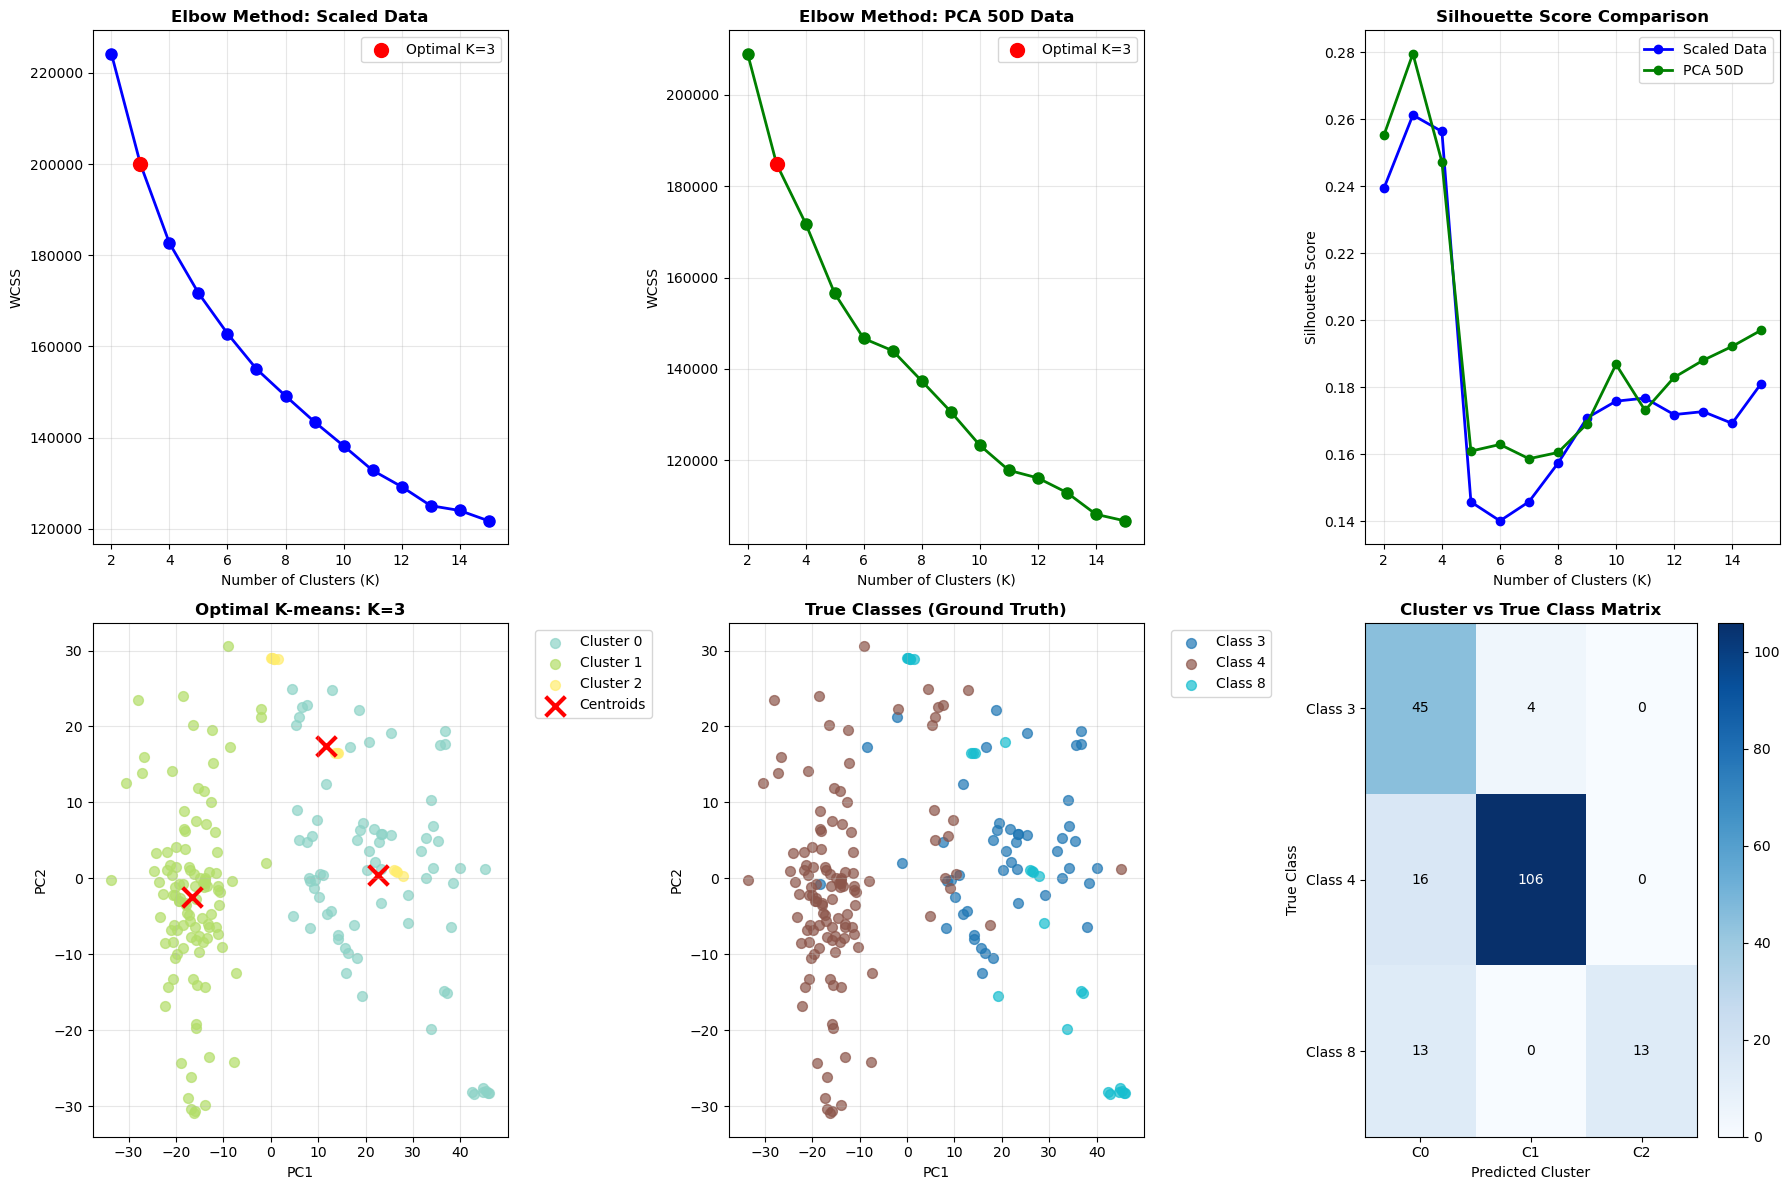

K-means visualization complete!


In [8]:
# ============================================================
# K-MEANS VISUALIZATION
# ============================================================

if "kmeans_results" in locals() and kmeans_results is not None:
    
    print("Creating K-means Analysis Visualizations...")
    
    # Create K-means analysis plots
    visualizer.plot_kmeans_analysis(
        k_range=range(2, 16),
        results=kmeans_results['elbow_analysis'],
        optimal_k_scaled=kmeans_results['optimal_k_scaled'],
        optimal_k_pca=kmeans_results['optimal_k_pca'],
        X_pca_2d=clustering_data['X_pca_2d'],
        optimal_labels=kmeans_results['optimal_labels'],
        centroids_2d=kmeans_results['centroids_2d'],
        y_true=clustering_data['y_labels'],
        n_clusters=kmeans_results['best_k']
    )
    
    print("K-means visualization complete!")
    
else:
    print("K-means results not available for visualization")
    print("   Please run the K-means clustering cells first")

In [9]:
# ============================================================
# MEAN SHIFT CLUSTERING
# ============================================================

if clustering_data is not None and "kmeans_results" in locals():
    print("Mean Shift Clustering Analysis")
    print("=" * 35)

    # Import advanced clustering utilities
    from src.clustering_utils import AdvancedClusteringAnalyzer
    
    # Extract data for clustering
    X_normalized = clustering_data["X_normalized"]
    X_pca_50 = clustering_data["X_pca_50"]
    X_pca_2d = clustering_data["X_pca_2d"]
    y_true = clustering_data["y_labels"]

    print(f"Mean Shift Setup:")
    print(f"   • Normalized data: {X_normalized.shape}")
    print(f"   • PCA 50D data: {X_pca_50.shape}")
    print(f"   • True classes: {len(np.unique(y_true))}")

    # Initialize advanced clustering analyzer
    advanced_analyzer = AdvancedClusteringAnalyzer()
    
    # Run Mean Shift clustering
    meanshift_results = advanced_analyzer.run_mean_shift(X_pca_50, X_normalized)
    
    print(f"\nMean Shift Results:")
    print(f"   • PCA data: {meanshift_results['pca']['n_clusters']} clusters found")
    print(f"   • Normalized data: {meanshift_results['normalized']['n_clusters']} clusters found (subset)")
    print(f"   • True classes: {len(np.unique(y_true))}")

    print("\nMean Shift clustering complete!")

else:
    print("No clustering data available or K-means results missing")
    print("   Please run the previous cells first")
    meanshift_results = None

Mean Shift Clustering Analysis
Mean Shift Setup:
   • Normalized data: (197, 1500)
   • PCA 50D data: (197, 50)
   • True classes: 3
Mean Shift Clustering

Mean Shift Results:
   • PCA data: 7 clusters found
   • Normalized data: 1 clusters found (subset)
   • True classes: 3

Mean Shift clustering complete!

Mean Shift Results:
   • PCA data: 7 clusters found
   • Normalized data: 1 clusters found (subset)
   • True classes: 3

Mean Shift clustering complete!


## 🌟 Mean Shift: Automatic Cluster Discovery

### Why Use Mean Shift?

**Key Advantage**: Automatically determines the number of clusters
- No need to specify K beforehand
- Finds natural modes (peaks) in data density

**How It Works**: 
- Each point "slides" toward areas of higher data density
- Points that converge to the same peak form a cluster
- Number of peaks = number of clusters

**Parameter**: Bandwidth controls cluster granularity
- Small bandwidth = many small clusters
- Large bandwidth = few large clusters

### **Mean Shift Clustering Algorithm**

**Mathematical Foundation:**
Mean Shift finds modes (peaks) in the probability density function using kernel density estimation:

$$m(x) = \frac{\sum_{i=1}^{n} K(x_i - x) \cdot x_i}{\sum_{i=1}^{n} K(x_i - x)} - x$$

Where:
- $m(x)$ = mean shift vector
- $K(x_i - x)$ = kernel function (typically Gaussian)
- Bandwidth determines kernel width

**Algorithm Concept:**
1. **Density Estimation**: Calculate local density around each point
2. **Mode Seeking**: Iteratively shift points toward density peaks
3. **Convergence**: Points converge to local maxima (modes)
4. **Clustering**: Points converging to same mode form cluster

**Key Properties:**
- **Bandwidth**: Critical parameter controlling cluster granularity
- **Non-parametric**: No assumption about cluster number or shape
- **Mode-based**: Natural cluster centers at density peaks
- **Complexity**: $O(n^2)$ - computationally expensive

**Bandwidth Selection:**
- **Small bandwidth**: Many small clusters, noise sensitivity
- **Large bandwidth**: Few large clusters, over-smoothing
- **Automatic estimation**: Using quantile of pairwise distances

**Strengths & Limitations:**
- ✅ **Pros**: Automatic $k$ selection, arbitrary cluster shapes, robust to outliers
- ❌ **Cons**: Slow on large datasets, bandwidth selection critical, memory intensive

In [10]:
# ============================================================
# DBSCAN CLUSTERING
# ============================================================

if "meanshift_results" in locals() and meanshift_results is not None:
    
    print("DBSCAN Clustering Analysis")
    print("=" * 30)
    
    # Run DBSCAN clustering with parameter optimization
    dbscan_results = advanced_analyzer.run_dbscan(X_pca_50)
    
    if dbscan_results is not None:
        print(f"\nDBSCAN Results:")
        print(f"   • Best eps: {dbscan_results['params']['eps']:.4f}")
        print(f"   • Best min_samples: {dbscan_results['params']['min_samples']}")
        print(f"   • Clusters found: {dbscan_results['n_clusters']}")
        print(f"   • Noise points: {dbscan_results['n_noise']}")
        print(f"   • Silhouette score: {dbscan_results['silhouette']:.3f}")
    else:
        print(f"\nDBSCAN: No suitable parameters found")
        
    print("\nDBSCAN clustering complete!")

else:
    print("Mean Shift results not available")
    print("   Please run the Mean Shift clustering cell first")
    dbscan_results = None

DBSCAN Clustering Analysis
DBSCAN Clustering

DBSCAN Results:
   • Best eps: 20.9880
   • Best min_samples: 3
   • Clusters found: 12
   • Noise points: 104
   • Silhouette score: 0.049

DBSCAN clustering complete!


## 🎯 DBSCAN: Density-Based Clustering

### DBSCAN's Unique Approach

**Density-Based**: Groups points in high-density regions, marks sparse areas as noise
- Perfect for real-world data with outliers
- Can find arbitrary cluster shapes (not just spherical)

**Key Innovation**: Automatic noise detection
- Points in low-density areas labeled as "noise"
- Robust to outliers and irregular patterns

**Parameters**:
- **ε (eps)**: Maximum distance for neighborhood
- **MinPts**: Minimum points to form a dense cluster

### **DBSCAN (Density-Based Spatial Clustering)**

**Mathematical Foundation:**
DBSCAN groups points that are densely packed while marking isolated points as noise:

**Core Concepts:**
- **ε-neighborhood**: Points within distance ε from point p: $N_ε(p) = \{q \in D | \text{dist}(p,q) ≤ ε\}$
- **Core point**: Point with at least `MinPts` neighbors in ε-neighborhood
- **Border point**: Non-core point within ε-neighborhood of a core point
- **Noise point**: Neither core nor border point

**Algorithm Steps:**
1. **For each unvisited point p:**
   - Find all points in ε-neighborhood
   - If neighborhood size ≥ MinPts → p is core point
2. **Create cluster** from core point and density-reachable points
3. **Assign border points** to nearest core point's cluster
4. **Mark remaining points** as noise

**Key Parameters:**
- **ε (eps)**: Maximum distance between points in same neighborhood
- **MinPts**: Minimum points required to form dense region
- **Distance metric**: Usually Euclidean, but customizable

**Parameter Selection Guidelines:**
- **ε**: Use k-distance plot (knee detection in sorted k-nearest distances)
- **MinPts**: Common rule: MinPts ≥ dimensions + 1
- **Domain knowledge**: Consider data characteristics and cluster expectations

**Strengths & Limitations:**
- ✅ **Pros**: Arbitrary cluster shapes, automatic noise detection, robust to outliers, no need to specify number of clusters
- ❌ **Cons**: Sensitive to parameters, struggles with varying densities, curse of dimensionality

In [11]:
# ============================================================
# ADVANCED CLUSTERING EVALUATION
# ============================================================

if "dbscan_results" in locals():
    
    print("Advanced Clustering Evaluation")
    print("=" * 35)
    
    # Calculate performance metrics for all methods
    from sklearn.metrics import silhouette_score, adjusted_rand_score
    
    # Extract labels from each method
    kmeans_labels = kmeans_results['optimal_labels']
    ms_labels = meanshift_results['pca']['labels']
    
    # Calculate metrics
    methods = ["K-means", "Mean Shift", "DBSCAN"]
    
    # K-means metrics (already calculated)
    kmeans_silhouette = kmeans_results['silhouette_score']
    kmeans_ari = kmeans_results['ari_score']
    
    # Convert labels to consistent numeric format for ARI calculation
    y_true_numeric = np.array([int(str(label)) for label in y_true])
    
    # Mean Shift metrics
    ms_silhouette = silhouette_score(X_pca_50, ms_labels) if meanshift_results['pca']['n_clusters'] > 1 else 0
    ms_ari = adjusted_rand_score(y_true_numeric, ms_labels)
    
    # DBSCAN metrics
    if dbscan_results is not None:
        db_silhouette = dbscan_results['silhouette']
        db_ari = adjusted_rand_score(y_true_numeric, dbscan_results['labels'])
        n_clusters_found = [kmeans_results['best_k'], meanshift_results['pca']['n_clusters'], dbscan_results['n_clusters']]
    else:
        db_silhouette = 0
        db_ari = 0
        n_clusters_found = [kmeans_results['best_k'], meanshift_results['pca']['n_clusters'], 0]
    
    silhouette_scores = [kmeans_silhouette, ms_silhouette, db_silhouette]
    ari_scores = [kmeans_ari, ms_ari, db_ari]
    
    print(f"\nPerformance Comparison:")
    for i, method in enumerate(methods):
        print(f"   • {method}:")
        print(f"     - Clusters: {n_clusters_found[i]}")
        print(f"     - Silhouette: {silhouette_scores[i]:.3f}")
        print(f"     - ARI: {ari_scores[i]:.3f}")
    
    # Store advanced clustering results
    advanced_clustering_results = {
        'meanshift': meanshift_results,
        'dbscan': dbscan_results,
        'performance_comparison': {
            'methods': methods,
            'n_clusters': n_clusters_found,
            'silhouette_scores': silhouette_scores,
            'ari_scores': ari_scores
        }
    }
    
    print("\nAdvanced clustering evaluation complete!")

else:
    print("Advanced clustering results not available")
    print("   Please run the previous clustering cells first")
    advanced_clustering_results = None

Advanced Clustering Evaluation

Performance Comparison:
   • K-means:
     - Clusters: 3
     - Silhouette: 0.280
     - ARI: 0.584
   • Mean Shift:
     - Clusters: 7
     - Silhouette: 0.097
     - ARI: 0.582
   • DBSCAN:
     - Clusters: 12
     - Silhouette: 0.049
     - ARI: 0.130

Advanced clustering evaluation complete!


## 📊 Clustering Performance Evaluation

### How to Measure Clustering Quality

**Challenge**: No single "correct" clustering - it's subjective!

**Internal Metrics** (no ground truth needed):
- **Silhouette Score**: Measures cluster separation and cohesion
- **Within-cluster sum of squares**: Tightness of clusters

**External Metrics** (compare against known labels):
- **Adjusted Rand Index (ARI)**: Measures agreement with true classes
- **Accuracy**: After optimal cluster-to-class assignment

**Business Context**: Best metric depends on your goal
- Pattern discovery vs known class validation

Creating Clustering Methods Comparison Visualization...


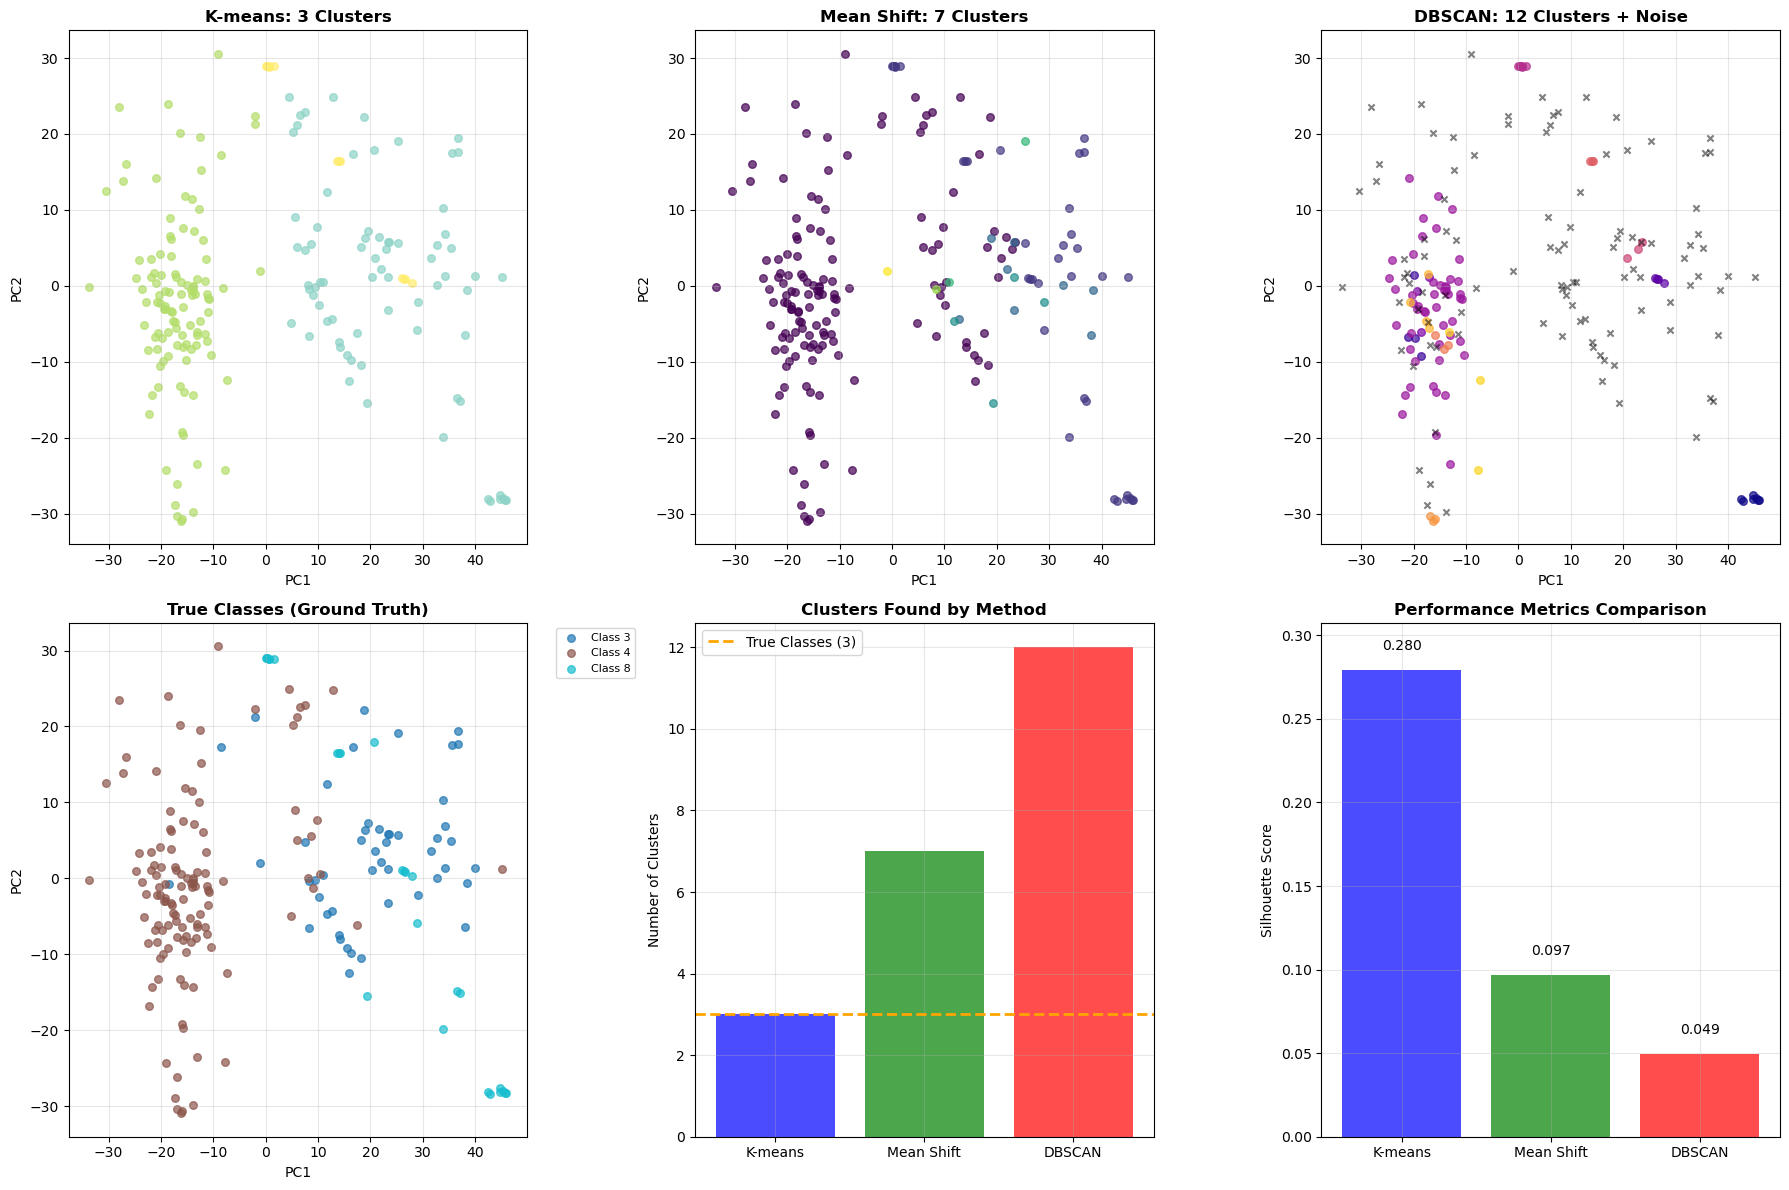

Clustering comparison visualization complete!


In [12]:
# ============================================================
# CLUSTERING METHODS COMPARISON VISUALIZATION
# ============================================================

if "advanced_clustering_results" in locals() and advanced_clustering_results is not None:
    
    print("Creating Clustering Methods Comparison Visualization...")
    
    # Create clustering comparison plots
    visualizer.plot_clustering_comparison(
        X_pca_2d=clustering_data['X_pca_2d'],
        kmeans_labels=kmeans_results['optimal_labels'],
        ms_labels=meanshift_results['pca']['labels'],
        dbscan_results=dbscan_results,
        y_true=clustering_data['y_labels'],
        methods=advanced_clustering_results['performance_comparison']['methods'],
        n_clusters_found=advanced_clustering_results['performance_comparison']['n_clusters'],
        silhouette_scores=advanced_clustering_results['performance_comparison']['silhouette_scores']
    )
    
    print("Clustering comparison visualization complete!")

else:
    print("Advanced clustering results not available for visualization")
    print("   Please run the previous clustering analysis cells first")

In [13]:
# ============================================================
# CLUSTER INTERPRETATION ANALYSIS
# ============================================================

if (
    "clustering_data" in locals()
    and clustering_data is not None
    and "kmeans_results" in locals()
    and kmeans_results is not None
    and "advanced_clustering_results" in locals()
    and advanced_clustering_results is not None
):

    print("Cluster Interpretation and Oil Well Operation Analysis")
    print("=" * 60)

    # Import analysis utilities
    import pandas as pd
    from scipy import stats

    # Extract data and results
    X_original = clustering_data["X_original"]
    X_pca_2d = clustering_data["X_pca_2d"]
    y_true = clustering_data["y_labels"]
    kmeans_labels = kmeans_results["optimal_labels"]
    n_clusters = kmeans_results["best_k"]

    print(f"Analysis Setup:")
    print(f"   • Total samples: {len(X_original)}")
    print(f"   • True oil well classes: {sorted(np.unique(y_true))}")
    print(f"   • K-means clusters: {n_clusters}")
    print(f"   • Feature dimensions: {X_original.shape[1]}")

    # Use evaluator to interpret clusters
    result = evaluator.interpret_clusters(y_true, kmeans_labels, X_original)
    if len(result) == 4:
        cluster_interpretations, cluster_class_matrix, unique_true_classes, unique_clusters = result
    else:
        # Backwards compatibility
        cluster_interpretations, cluster_class_matrix = result
        unique_true_classes = sorted(np.unique([int(str(label)) for label in y_true]))
        unique_clusters = sorted(np.unique(kmeans_labels))
    
    print(f"\nCluster-Class Correspondence Analysis:")
    cluster_class_df = pd.DataFrame(
        cluster_class_matrix,
        index=[f"True Class {i}" for i in unique_true_classes],
        columns=[f"Cluster {i}" for i in unique_clusters],
    )
    print(cluster_class_df.to_string())

    # Calculate clustering accuracy using the Hungarian algorithm for optimal assignment
    from scipy.optimize import linear_sum_assignment
    
    # Find optimal cluster-to-class assignment
    cost_matrix = -cluster_class_matrix  # Negative because we want to maximize matches
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Calculate accuracy based on optimal assignment
    optimal_matches = cluster_class_matrix[row_indices, col_indices].sum()
    total_samples = cluster_class_matrix.sum()
    clustering_accuracy = optimal_matches / total_samples
    
    print(f"\nClustering Performance Metrics:")
    print(f"   • Optimal Cluster-Class Assignment Accuracy: {clustering_accuracy:.3f} ({clustering_accuracy*100:.1f}%)")
    print(f"   • Optimal Assignment Mapping:")
    for true_class_idx, cluster_idx in zip(row_indices, col_indices):
        true_class = unique_true_classes[true_class_idx]
        cluster = unique_clusters[cluster_idx]
        matches = cluster_class_matrix[true_class_idx, cluster_idx]
        print(f"     - Class {true_class} → Cluster {cluster}: {matches} samples")

    # Display cluster interpretations
    print(f"\nCluster Interpretations:")
    for cluster_id, interpretation in cluster_interpretations.items():
        print(f"   • Cluster {cluster_id}: {interpretation['size']} samples ({interpretation['size']/len(kmeans_labels)*100:.1f}%)")
        print(f"     - Dominant: Class {interpretation['dominant_class']} ({interpretation['dominant_percentage']:.1f}%)")
        print(f"     - Operation: {interpretation['operation_type']}")
        print(f"     - Description: {interpretation['description']}")

    print("\nCluster interpretation analysis complete!")

else:
    print("Missing required data or results")
    print("   Please run all previous clustering cells first")
    cluster_interpretations = None
    cluster_class_matrix = None

Cluster Interpretation and Oil Well Operation Analysis
Analysis Setup:
   • Total samples: 197
   • True oil well classes: [np.str_('3'), np.str_('4'), np.str_('8')]
   • K-means clusters: 3
   • Feature dimensions: 1500

Cluster-Class Correspondence Analysis:
              Cluster 0  Cluster 1  Cluster 2
True Class 3         45          4          0
True Class 4         16        106          0
True Class 8         13          0         13

Clustering Performance Metrics:
   • Optimal Cluster-Class Assignment Accuracy: 0.832 (83.2%)
   • Optimal Assignment Mapping:
     - Class 3 → Cluster 0: 45 samples
     - Class 4 → Cluster 1: 106 samples
     - Class 8 → Cluster 2: 13 samples

Cluster Interpretations:
   • Cluster 0: 74 samples (37.6%)
     - Dominant: Class 3 (60.8%)
     - Operation: Flow-related Issues
     - Description: Problems with flow rates, possibly low production or blockages
   • Cluster 1: 110 samples (55.8%)
     - Dominant: Class 4 (96.4%)
     - Operation: Pressur

## 🔍 Cluster Interpretation for Oil Well Operations

### Making Clustering Results Actionable

**The Translation Challenge**: Clusters are just numbers - what do they mean operationally?

**Interpretation Process**:
1. **Match clusters to known fault types** using class distribution
2. **Analyze feature patterns** within each cluster 
3. **Identify operational characteristics** of each cluster

**Business Value**:
- **Pattern Discovery**: Find unknown operational modes
- **Fault Classification**: Group similar failure types
- **Predictive Insights**: Understand what leads to different outcomes

**Quality Metrics**:
- **Cluster Purity**: How well clusters align with known classes
- **Cluster Coherence**: How similar are patterns within clusters

Creating Cluster Interpretation Visualization...


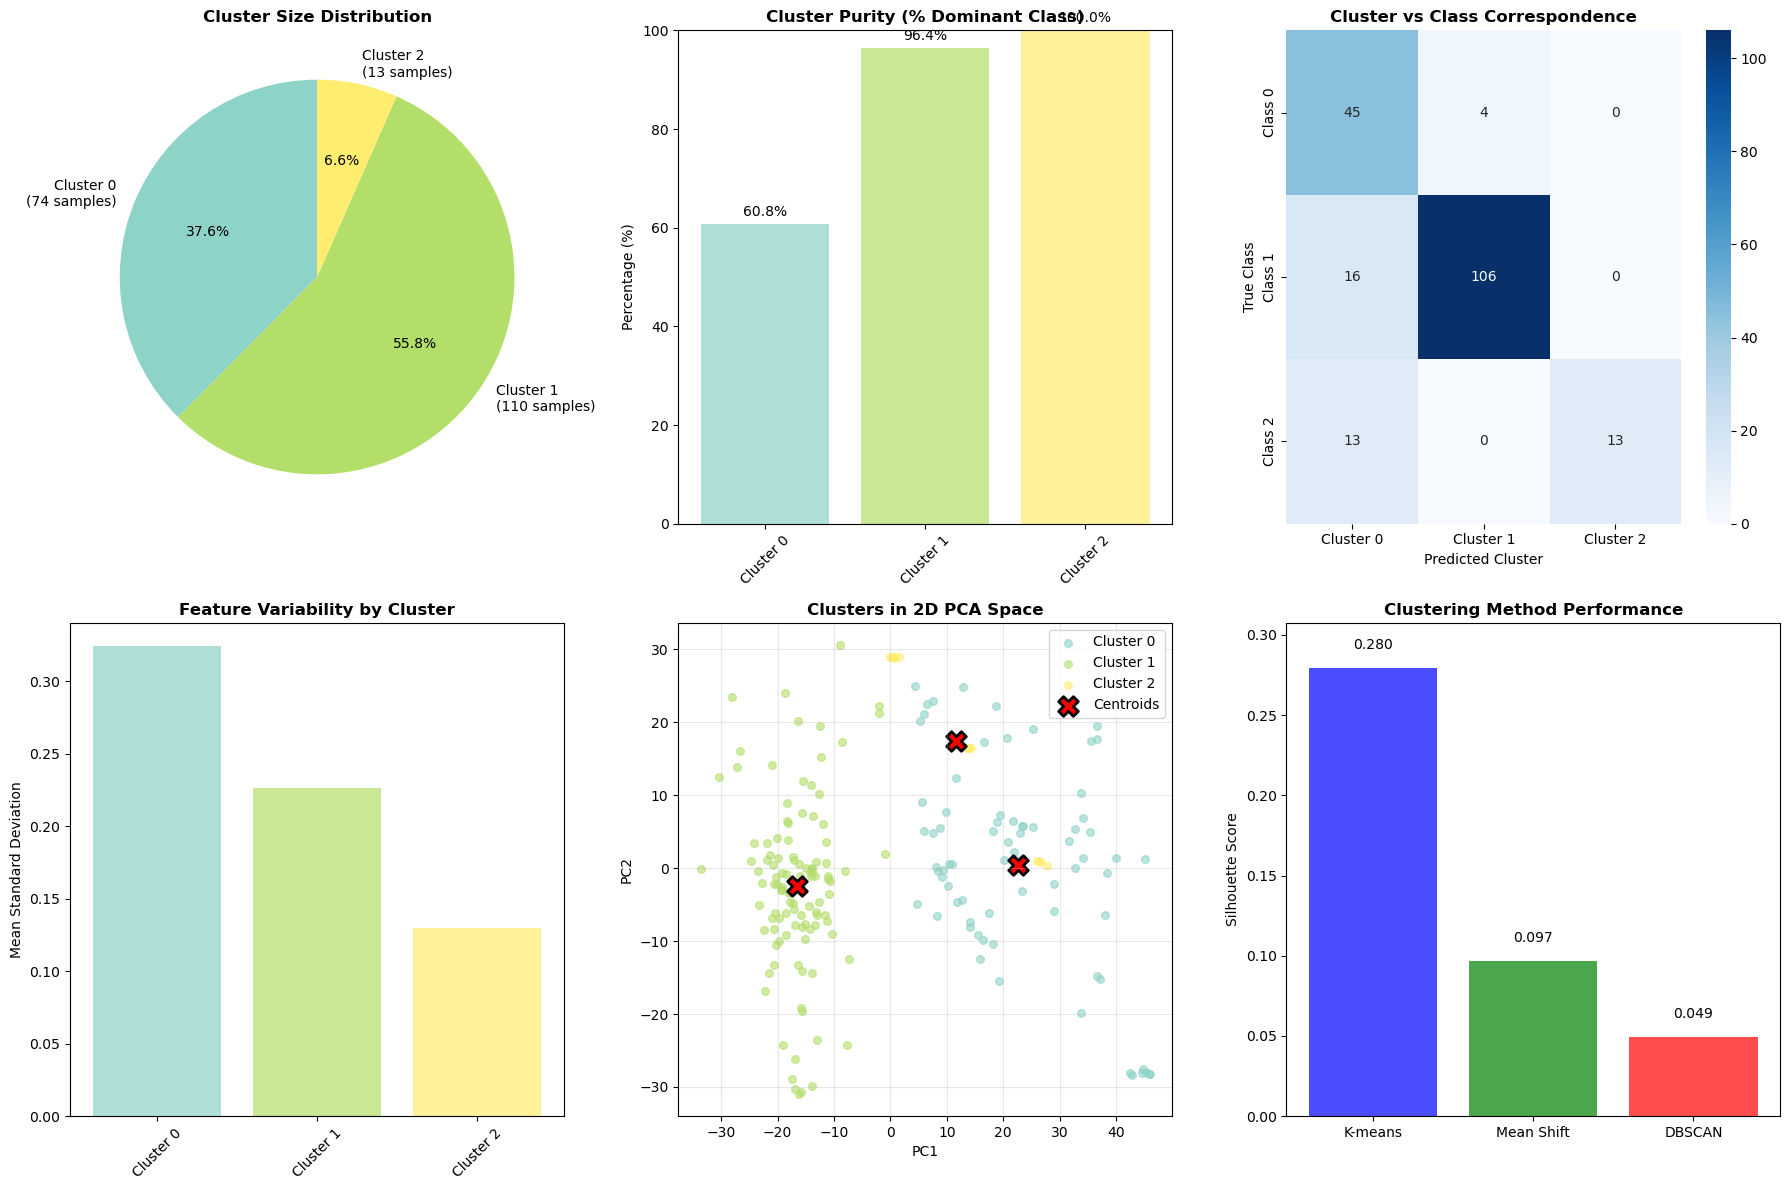

Cluster interpretation visualization complete!


In [14]:
# ============================================================
# CLUSTER INTERPRETATION VISUALIZATION
# ============================================================

if "cluster_interpretations" in locals() and cluster_interpretations is not None:
    
    print("Creating Cluster Interpretation Visualization...")
    
    # Prepare feature statistics for visualization
    cluster_feature_stats = {}
    for cluster_id, interpretation in cluster_interpretations.items():
        cluster_feature_stats[cluster_id] = interpretation['feature_stats']
    
    # Create cluster interpretation plots
    visualizer.plot_cluster_interpretation(
        cluster_interpretations=cluster_interpretations,
        cluster_class_matrix=cluster_class_matrix,
        cluster_feature_stats=cluster_feature_stats,
        X_pca_2d=clustering_data['X_pca_2d'],
        kmeans_labels=kmeans_results['optimal_labels'],
        centroids_2d=kmeans_results['centroids_2d'],
        silhouette_scores=advanced_clustering_results['performance_comparison']['silhouette_scores'],
        methods=advanced_clustering_results['performance_comparison']['methods']
    )
    
    print("Cluster interpretation visualization complete!")

else:
    print("Cluster interpretation data not available")
    print("   Please run the cluster interpretation analysis cell first")

In [15]:
# ============================================================
# FINAL ANALYSIS SUMMARY
# ============================================================

if "cluster_interpretations" in locals() and cluster_interpretations is not None:
    
    print("Final Clustering Analysis Summary")
    print("=" * 40)

    # Calculate summary statistics
    methods = advanced_clustering_results['performance_comparison']['methods']
    silhouette_scores = advanced_clustering_results['performance_comparison']['silhouette_scores']
    
    best_method = methods[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)
    
    # Calculate average cluster purity
    cluster_purities = [cluster_interpretations[i]['dominant_percentage'] for i in range(n_clusters)]
    avg_purity = np.mean(cluster_purities)

    print(f"\nClustering Performance Summary:")
    print(f"   • Best performing method: {best_method} (Silhouette: {best_score:.3f})")
    print(f"   • Average cluster purity: {avg_purity:.1f}%")
    print(f"   • Number of clusters found: {n_clusters}")
    print(f"   • True classes in dataset: {len(np.unique(y_true))}")

    print(f"\nPattern Discovery Results:")
    if avg_purity > 70:
        print(f"   High cluster purity ({avg_purity:.1f}%) - clusters align well with true classes")
    elif avg_purity > 50:
        print(f"   Moderate cluster purity ({avg_purity:.1f}%) - some mixing between classes")
    else:
        print(f"   Low cluster purity ({avg_purity:.1f}%) - significant class mixing")

    # Identify most distinct operational patterns
    most_pure_cluster = np.argmax(cluster_purities)
    most_distinct_class = cluster_interpretations[most_pure_cluster]['dominant_class']

    print(f"\nOperational Pattern Analysis:")
    print(f"   • Most distinct pattern: Cluster {most_pure_cluster}")
    print(f"     - Represents Class {most_distinct_class} operations")
    print(f"     - Purity: {cluster_purities[most_pure_cluster]:.1f}%")
    print(f"     - Size: {cluster_interpretations[most_pure_cluster]['size']} samples")
    print(f"     - Operation: {cluster_interpretations[most_pure_cluster]['operation_type']}")

    if n_clusters > len(np.unique(y_true)):
        print(f"   • {n_clusters} clusters > {len(np.unique(y_true))} classes suggests sub-patterns within operations")
    elif n_clusters < len(np.unique(y_true)):
        print(f"   • {n_clusters} clusters < {len(np.unique(y_true))} classes suggests some operations are similar")

    # Store final comprehensive results
    clustering_insights = {
        'cluster_interpretations': cluster_interpretations,
        'performance_summary': {
            'best_method': best_method,
            'best_silhouette': best_score,
            'average_purity': avg_purity,
            'most_distinct_cluster': most_pure_cluster,
        },
        'analysis_complete': True
    }

    print(f"\nComplete Clustering Analysis Finished!")
    print(f"Results stored in 'clustering_insights' for further analysis.")

else:
    print("Cannot generate final summary - cluster interpretations not available")
    clustering_insights = None

Final Clustering Analysis Summary

Clustering Performance Summary:
   • Best performing method: K-means (Silhouette: 0.280)
   • Average cluster purity: 85.7%
   • Number of clusters found: 3
   • True classes in dataset: 3

Pattern Discovery Results:
   High cluster purity (85.7%) - clusters align well with true classes

Operational Pattern Analysis:
   • Most distinct pattern: Cluster 2
     - Represents Class 8 operations
     - Purity: 100.0%
     - Size: 13 samples
     - Operation: Severe Faults

Complete Clustering Analysis Finished!
Results stored in 'clustering_insights' for further analysis.


---

# 🚀 Advanced Clustering Section

## Enhanced Algorithm Implementations & Interactive Visualizations

*This section provides advanced clustering techniques and enhanced visualizations for deeper analysis.*

In [16]:
# ============================================================
# ADVANCED ALGORITHM IMPLEMENTATIONS
# ============================================================

# Import advanced clustering utilities
from src.clustering_utils import AdvancedClusteringSuite

# Initialize advanced clustering suite
if 'clustering_data' in locals() and clustering_data is not None:
    print("Initializing Advanced Clustering Suite...")
    
    advanced_suite = AdvancedClusteringSuite()
    
    # Run advanced clustering with multiple algorithms
    advanced_results = advanced_suite.run_advanced_clustering_suite(
        X_data=clustering_data['X_pca_50'], 
        y_true=clustering_data['y_labels'], 
        max_k=8
    )
    
    print(f"\n📊 Advanced clustering results available for visualization!")
    
else:
    print("❌ Clustering data not available. Run previous cells first.")
    advanced_results = None

Initializing Advanced Clustering Suite...
🔬 Advanced Clustering Suite
1. Enhanced K-means with K-means++
   ✓ Best K: 3, Silhouette: 0.280
2. Gaussian Mixture Models (GMM)
   ✓ Best Components: 3, Silhouette: 0.280
3. Hierarchical Clustering (Multiple Linkages)
   ✓ Best: 3 clusters, ward linkage
     Silhouette: 0.274
4. Optimized DBSCAN with Grid Search
   ✓ Best K: 3, Silhouette: 0.280
2. Gaussian Mixture Models (GMM)
   ✓ Best Components: 3, Silhouette: 0.280
3. Hierarchical Clustering (Multiple Linkages)
   ✓ Best: 3 clusters, ward linkage
     Silhouette: 0.274
4. Optimized DBSCAN with Grid Search
   ✓ Best: eps=30.829, min_samples=4
     Clusters: 5, Noise: 52
     Silhouette: 0.251

🏆 Advanced Clustering Complete!

📊 Advanced clustering results available for visualization!
   ✓ Best: eps=30.829, min_samples=4
     Clusters: 5, Noise: 52
     Silhouette: 0.251

🏆 Advanced Clustering Complete!

📊 Advanced clustering results available for visualization!


## 🚀 Advanced Clustering Techniques

### Beyond Basic Algorithms

**Enhanced Methods**: More sophisticated versions of standard algorithms
- **Enhanced K-means**: Better initialization and convergence
- **Gaussian Mixture Models**: Probabilistic clustering with soft assignments
- **Hierarchical Clustering**: Tree-based cluster discovery
- **Optimized DBSCAN**: Automatic parameter tuning

**Why Advanced Methods?**
- Better handling of complex data patterns
- More robust parameter selection
- Improved clustering quality for industrial data

Creating Advanced Clustering Comparison Visualization...
🎨 Creating Advanced Visualizations
1. Multi-Algorithm Comparison Dashboard


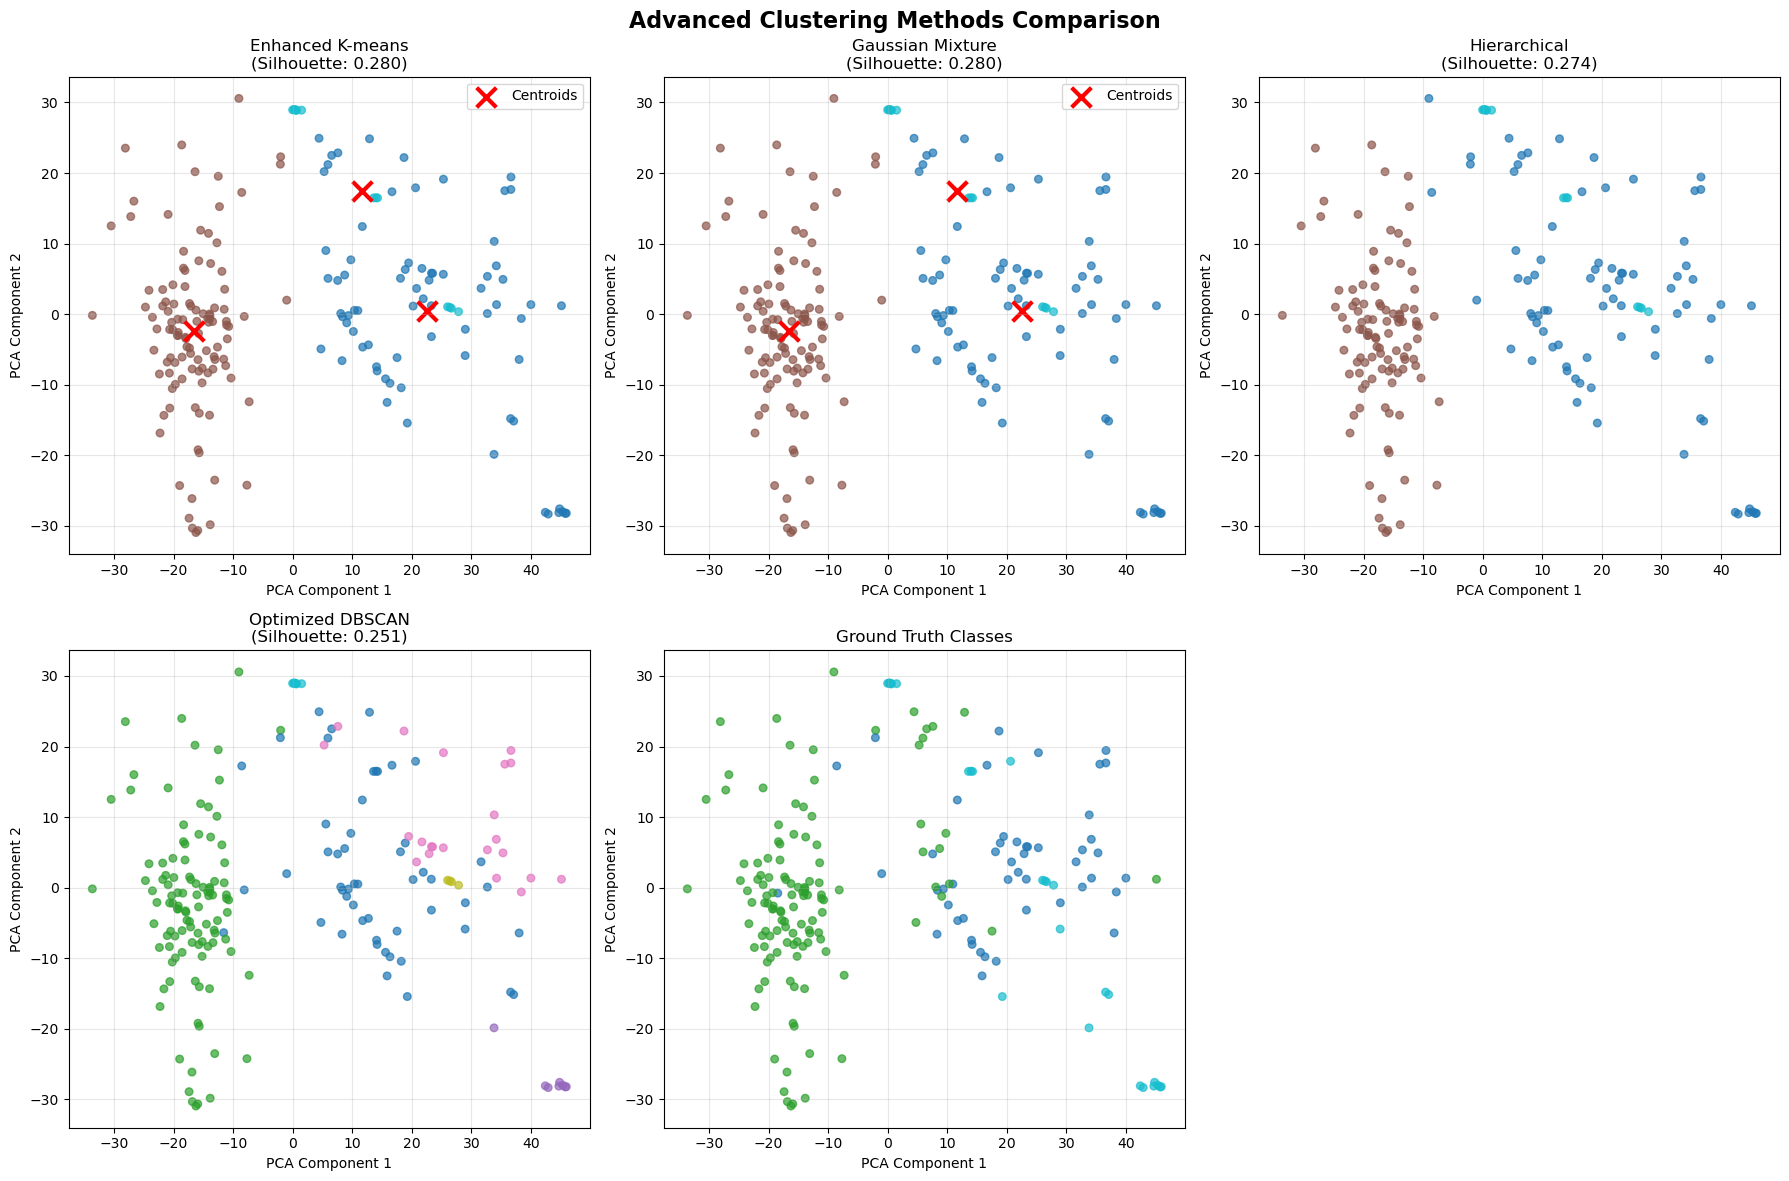


🎨 Advanced Visualizations Complete!


In [17]:
# ============================================================
# ADVANCED VISUALIZATION: CLUSTER COMPARISON WITH CENTERS
# ============================================================

# Import advanced visualization utilities
from src.clustering_visualization import AdvancedClusteringVisualizer

if advanced_results is not None and 'clustering_data' in locals():
    print("Creating Advanced Clustering Comparison Visualization...")
    
    # Initialize advanced visualizer
    advanced_visualizer = AdvancedClusteringVisualizer()
    
    # Create comprehensive advanced visualizations showing cluster centers and ground truth
    advanced_visualizer.create_advanced_visualizations(
        clustering_data=clustering_data,
        advanced_results=advanced_results,
        original_results={'kmeans': kmeans_results} if 'kmeans_results' in locals() else None
    )
    
else:
    print("❌ Advanced results not available. Run the advanced clustering cell first.")

### **Hungarian Algorithm for Clustering Accuracy**

**Problem**: How to fairly compare clustering results with ground truth when cluster labels are arbitrary?

**Solution**: The **Hungarian Algorithm** finds the optimal assignment between predicted clusters and true classes.

**Mathematical Foundation:**

Given a **cost matrix** $C$ where $C_{ij}$ represents the cost of assigning true class $i$ to predicted cluster $j$:

$$\text{Minimize: } \sum_{i,j} C_{ij} \cdot x_{ij}$$

Subject to:
- $\sum_j x_{ij} = 1$ (each true class assigned to exactly one cluster)
- $\sum_i x_{ij} = 1$ (each cluster assigned to exactly one true class)  
- $x_{ij} \in \{0,1\}$ (binary assignment)

**For Clustering Accuracy:**
- $C_{ij} = -\text{count}_{ij}$ (negative because we want to **maximize** matches)
- $\text{count}_{ij}$ = number of samples with true class $i$ in predicted cluster $j$

**Algorithm Steps:**
1. **Build confusion matrix**: Count samples for each (true_class, predicted_cluster) pair
2. **Apply Hungarian algorithm**: Find optimal assignment that maximizes total matches
3. **Calculate accuracy**: $\text{Accuracy} = \frac{\text{Total Optimal Matches}}{\text{Total Samples}}$

**Why Use This?**
- **Fair comparison**: Handles arbitrary cluster labels (cluster 0 might correspond to class 3)
- **Optimal assignment**: Guarantees best possible accuracy for any label permutation
- **Robust metric**: Works even when number of clusters ≠ number of true classes

In [18]:
# ============================================================
# CLUSTERING ACCURACY EVALUATION
# ============================================================

if advanced_results is not None and 'clustering_data' in locals():
    print("🎯 Evaluating Clustering Accuracy Against Ground Truth")
    print("=" * 55)
    
    from scipy.optimize import linear_sum_assignment
    import numpy as np
    
    # Extract ground truth labels
    y_true = clustering_data['y_labels']
    y_true_numeric = np.array([int(str(label)) if isinstance(label, (str, np.str_)) else label for label in y_true])
    
    # Function to calculate accuracy using Hungarian algorithm for optimal assignment
    def calculate_clustering_accuracy(y_true, y_pred):
        """Calculate clustering accuracy using optimal label assignment"""
        true_labels, pred_labels = np.unique(y_true), np.unique(y_pred)
        n_true, n_pred = len(true_labels), len(pred_labels)
        
        # Create confusion matrix
        confusion_matrix = np.zeros((n_true, n_pred))
        for i, true_label in enumerate(true_labels):
            for j, pred_label in enumerate(pred_labels):
                confusion_matrix[i, j] = np.sum((y_true == true_label) & (y_pred == pred_label))
        
        # Use Hungarian algorithm for optimal assignment
        row_indices, col_indices = linear_sum_assignment(-confusion_matrix)
        accuracy = confusion_matrix[row_indices, col_indices].sum() / len(y_true)
        
        return accuracy, confusion_matrix, row_indices, col_indices
    
    # Advanced clustering methods to evaluate
    methods_info = [
        ('enhanced_kmeans', 'Enhanced K-means'),
        ('gmm', 'Gaussian Mixture Model'), 
        ('hierarchical', 'Hierarchical Clustering'),
        ('optimized_dbscan', 'Optimized DBSCAN')
    ]
    
    print("📊 Clustering Method Accuracy Results:")
    print("-" * 50)
    
    accuracy_results = {}
    
    # Evaluate advanced methods
    for method_key, method_name in methods_info:
        if method_key in advanced_results and advanced_results[method_key] is not None:
            labels = advanced_results[method_key]['labels']
            labels_numeric = np.array([int(str(label)) if isinstance(label, (str, np.str_)) else label for label in labels])
            
            accuracy, conf_matrix, row_ind, col_ind = calculate_clustering_accuracy(y_true_numeric, labels_numeric)
            accuracy_results[method_name] = {
                'accuracy': accuracy, 'n_clusters': len(np.unique(labels_numeric)),
                'confusion_matrix': conf_matrix, 'assignment': (row_ind, col_ind)
            }
            print(f"   • {method_name:<25}: {accuracy:.3f} ({accuracy*100:.1f}%) | Clusters: {len(np.unique(labels_numeric))}")
    
    # Add basic K-means for comparison
    if 'kmeans_results' in locals() and kmeans_results is not None:
        kmeans_labels = kmeans_results['optimal_labels']
        accuracy, conf_matrix, row_ind, col_ind = calculate_clustering_accuracy(y_true_numeric, kmeans_labels)
        accuracy_results['Basic K-means'] = {
            'accuracy': accuracy, 'n_clusters': len(np.unique(kmeans_labels)),
            'confusion_matrix': conf_matrix, 'assignment': (row_ind, col_ind)
        }
        print(f"   • {'Basic K-means':<25}: {accuracy:.3f} ({accuracy*100:.1f}%) | Clusters: {len(np.unique(kmeans_labels))}")
    
    # Display results
    if accuracy_results:
        best_method = max(accuracy_results.items(), key=lambda x: x[1]['accuracy'])
        unique_true_classes = np.unique(y_true_numeric)
        
        print(f"\n🏆 Best Performing Method: {best_method[0]} ({best_method[1]['accuracy']*100:.1f}%)")
    
    print(f"\n✅ Accuracy evaluation complete!")
    
else:
    print("❌ Advanced results not available. Run the advanced clustering cell first.")

🎯 Evaluating Clustering Accuracy Against Ground Truth
📊 Clustering Method Accuracy Results:
--------------------------------------------------
   • Enhanced K-means         : 0.832 (83.2%) | Clusters: 3
   • Gaussian Mixture Model   : 0.832 (83.2%) | Clusters: 3
   • Hierarchical Clustering  : 0.838 (83.8%) | Clusters: 3
   • Optimized DBSCAN         : 0.716 (71.6%) | Clusters: 6
   • Basic K-means            : 0.832 (83.2%) | Clusters: 3

🏆 Best Performing Method: Hierarchical Clustering (83.8%)

✅ Accuracy evaluation complete!


## 🎯 Workshop Summary: Clustering for Pattern Discovery

### Key Learning Outcomes

**Clustering Fundamentals**:
- Unsupervised pattern discovery without labeled data
- Different algorithms suit different data characteristics
- Parameter selection critically affects results

**Algorithm Comparison**:
- **K-means**: Fast, simple, requires K specification
- **Mean Shift**: Automatic K, finds density peaks
- **DBSCAN**: Handles noise, arbitrary shapes
- **Advanced Methods**: Better robustness and automation

**Practical Insights**:
- Preprocessing significantly impacts clustering quality
- Multiple evaluation metrics provide different perspectives  
- Business interpretation transforms clusters into actionable insights

### Real-World Applications

**Industrial Monitoring**: Discover unknown operational patterns
**Predictive Maintenance**: Group similar degradation signatures
**Quality Control**: Identify product variation patterns
**Customer Segmentation**: Find natural customer groups

### Next Steps
- Apply to your own time series data
- Experiment with feature engineering
- Combine clustering with domain knowledge
- Use clusters as input for supervised learning